# Imports

In [1]:
from pathlib import Path
import warnings

warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import utils
from prophet import Prophet
from pathlib import Path

In [60]:
X, y = utils.get_train_data()

In [61]:
len(y), X.shape

(496827, (496827, 10))

In [62]:
def train_test_split_temporal(X, y, delta_threshold="30 days"):
    cutoff_date = X["date"].max() - pd.Timedelta(delta_threshold)
    mask = X["date"] <= cutoff_date
    X_train, X_test = X.loc[mask], X.loc[~mask]
    y_train, y_test = y[mask], y[~mask]

    return X_train, y_train, X_test, y_test

In [63]:
X_train, y_train, X_test, y_test = train_test_split_temporal(
    X, y, delta_threshold="30 days"
)

# PROPHET

In [65]:
data = pd.read_parquet(Path("data") / "train.parquet")
data = data[data['counter_id'] == '100007049-102007049']

In [57]:
# creating a df for prophet

df_train["y"] = pd.Series(y_train)

df_train = df_train[["date", "latitude", "longitude", "y"]]
df_train.rename(columns={"date": "ds"}, inplace=True)

In [58]:
df_train.head()

,ds,latitude,longitude,y
0,2020-09-01 01:00:00,48.840801,2.333233,1.609438
1,2020-09-01 01:00:00,48.840801,2.333233,1.386294
2,2020-09-01 01:00:00,48.853720,2.357020,0.000000
3,2020-09-01 01:00:00,48.853720,2.357020,0.693147
4,2020-09-01 01:00:00,48.885290,2.326660,2.079442


In [103]:
X_train, y_train, X_test, y_test = train_test_split_temporal(
    data[['date','log_bike_count']], data['log_bike_count'], delta_threshold="30 days"
)

X_train.rename(columns={'date':'ds','log_bike_count':'y'},inplace=True)
X_test.rename(columns={'date':'ds','log_bike_count':'y'},inplace=True)

In [116]:
model = Prophet()

In [117]:
model.fit(X_train)

18:53:05 - cmdstanpy - INFO - Chain [1] start processing
18:53:05 - cmdstanpy - INFO - Chain [1] done processing


In [118]:
future = model.make_future_dataframe(periods=30)  # Adjust 'periods' as needed

In [119]:
forecast = model.predict(future)

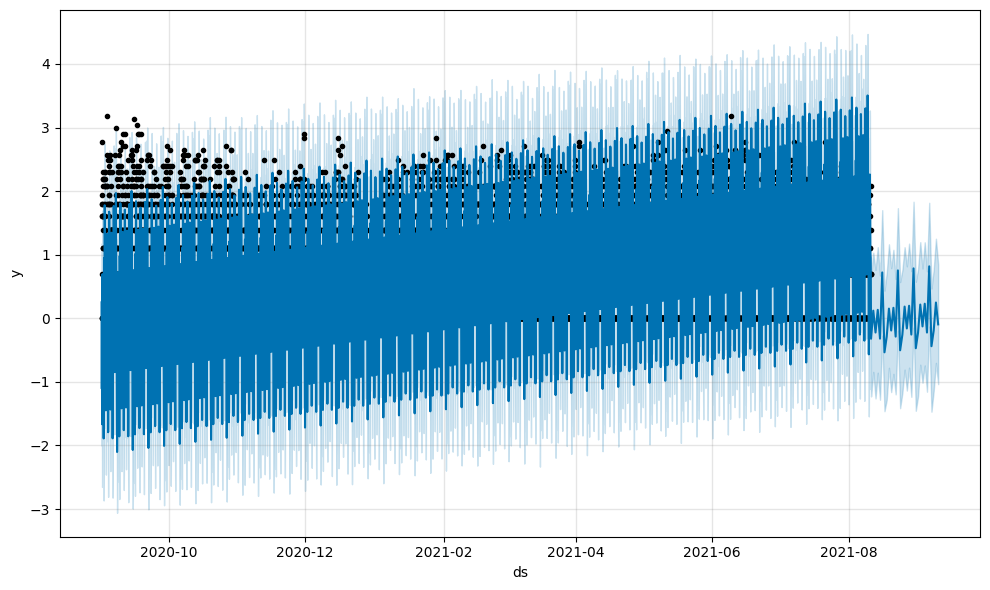

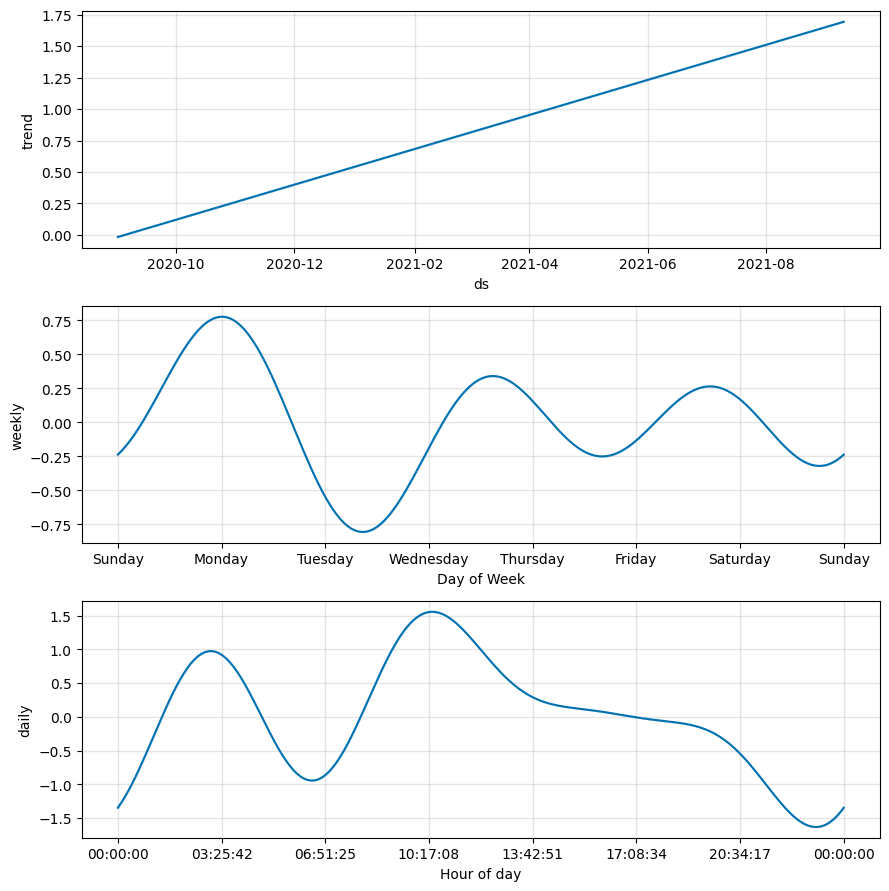

In [120]:
fig1 = model.plot(forecast)
fig2 = model.plot_components(forecast)

# XGBoost

In [38]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder

from sklearn.pipeline import make_pipeline

In [39]:
X_final_test = pd.read_parquet(Path("data") / "final_test.parquet")
X, y = utils.get_train_data()

## Data prep

In [40]:
cols = ['date','latitude','longitude','counter_installation_date']

In [41]:
def _encode_dates(X):
    X = X.copy()  # modify a copy of X
    # Encode the date information from the DateOfDeparture columns
    X["year"] = X["date"].dt.year
    X["month"] = X["date"].dt.month
    X["day"] = X["date"].dt.day
    X["weekday"] = X["date"].dt.weekday
    X["hour"] = X["date"].dt.hour

    # Finally we can drop the original columns from the dataframe
    return X.drop(columns=["date"])



In [42]:
### Weather Dataset cleaning
weather_wi = pd.read_csv('data/weather_data_paris_daily.csv')
columns_to_keep = ['datetime', 'temp', 'precip', 'windspeed', 'visibility']
weather = weather_wi[columns_to_keep].copy().rename(columns={'datetime':'date'})
mapping = {'snow': 0, 'rain': 1, 'cloudy': 2, 'partly-cloudy-day': 3, 'clear-day': 4}
weather.loc[:, 'icon_encoded'] = weather_wi['icon'].copy().map(mapping)
weather['date'] = pd.to_datetime(weather['date'].values.astype('<M8[us]'), format='%Y-%m-%d')
weather['date_merge'] = weather['date']

In [43]:
X_weather = X.copy() 
X_weather['date_merge'] = pd.to_datetime(X_weather['date'].dt.strftime('%Y-%m-%d'), format='%Y-%m-%d')
X_weather = X_weather.merge(weather.drop(columns=['date']), how='left', on='date_merge').drop(columns=['date_merge'])
X_weather.head()

,counter_id,counter_name,site_id,site_name,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude,temp,precip,windspeed,visibility,icon_encoded
0,100049407-353255860,152 boulevard du Montparnasse E-O,100049407,152 boulevard du Montparnasse,2020-09-01 01:00:00,2018-12-07,"48.840801,2.333233",Y2H19070373,48.840801,2.333233,16.1,0.0,13.6,25.1,3
1,100049407-353255859,152 boulevard du Montparnasse O-E,100049407,152 boulevard du Montparnasse,2020-09-01 01:00:00,2018-12-07,"48.840801,2.333233",Y2H19070373,48.840801,2.333233,16.1,0.0,13.6,25.1,3
2,100036719-104036719,18 quai de l'Hôtel de Ville NO-SE,100036719,18 quai de l'Hôtel de Ville,2020-09-01 01:00:00,2017-07-12,"48.85372,2.35702",Y2H19027732,48.853720,2.357020,16.1,0.0,13.6,25.1,3
3,100036719-103036719,18 quai de l'Hôtel de Ville SE-NO,100036719,18 quai de l'Hôtel de Ville,2020-09-01 01:00:00,2017-07-12,"48.85372,2.35702",Y2H19027732,48.853720,2.357020,16.1,0.0,13.6,25.1,3
4,100063175-353277233,20 Avenue de Clichy NO-SE,100063175,20 Avenue de Clichy,2020-09-01 01:00:00,2020-07-22,"48.88529,2.32666",Y2H20073268,48.885290,2.326660,16.1,0.0,13.6,25.1,3


In [44]:
def train_test_split_temporal(X, y, delta_threshold="30 days"):
    
    cutoff_date = X["date"].max() - pd.Timedelta(delta_threshold)
    mask = X["date"] <= cutoff_date
    X_train, X_test = X.loc[mask], X.loc[~mask]
    y_train, y_test = y[mask], y[~mask]

    return X_train, y_train, X_test, y_test

In [45]:
X_train, y_train, X_test, y_test = train_test_split_temporal(X_weather, y, delta_threshold="30 days")

date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[["date","counter_installation_date"]]).columns.tolist()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = []

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols)
        #("cat", categorical_encoder, categorical_cols),
    ]
)

## Model

In [56]:
model = xgb.XGBRegressor(colsample_bynode=0.6,
        colsample_bytree=0.6,
        colsample_bylevel=0.5,
        learning_rate=0.1,
        n_estimators=400,
        max_depth=10,
        subsample=0.8)

pipe = make_pipeline(date_encoder, preprocessor, model)
pipe.fit(X_train, y_train)

predictions = pipe.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'Mean Squared Error: {rmse}')

Mean Squared Error: 0.6309906194405339


In [54]:
pipe.predict(X_final_test)

array([0.85317886, 2.8342109 , 3.5677972 , ..., 5.079897  , 4.6430626 ,
       3.8490362 ], dtype=float32)

In [48]:
pipe.predict(X_test)

array([1.2352403, 1.2352403, 1.2637948, ..., 3.3482354, 2.3267992,
       2.3267992], dtype=float32)

In [49]:
X_final_test = pd.read_parquet(Path("data") / "final_test.parquet")
X_final_test['date_merge'] = pd.to_datetime(X_final_test['date'].dt.strftime('%Y-%m-%d'), format='%Y-%m-%d')
X_final_test = X_final_test.merge(weather.drop(columns=['date']), how='left', on='date_merge').drop(columns=['date_merge'])
X_final_test.head()

,counter_id,counter_name,site_id,site_name,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude,temp,precip,windspeed,visibility,icon_encoded
0,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 01:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,19.9,0.931,14.3,20.8,1
1,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 13:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,19.9,0.931,14.3,20.8,1
2,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 17:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,19.9,0.931,14.3,20.8,1
3,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 19:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,19.9,0.931,14.3,20.8,1
4,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 22:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,19.9,0.931,14.3,20.8,1


In [50]:
submission = pipe.predict(X_final_test)
pd.Series(submission).to_frame().rename_axis('Id').rename(columns={0:'log_bike_count'}).to_csv('submission3_61223.csv')

In [23]:
X_final_test

,counter_id,counter_name,site_id,site_name,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude,temp,precip,windspeed,visibility,icon_encoded
0,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 01:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,19.9,0.931,14.3,20.8,1
1,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 13:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,19.9,0.931,14.3,20.8,1
2,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 17:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,19.9,0.931,14.3,20.8,1
3,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 19:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,19.9,0.931,14.3,20.8,1
4,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 22:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,19.9,0.931,14.3,20.8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51435,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,2021-10-18 11:00:00,2020-11-29,"48.83977,2.30198",Y2H20114504,48.839770,2.301980,12.2,1.543,15.3,16.7,1
51436,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,2021-10-18 15:00:00,2020-11-29,"48.83977,2.30198",Y2H20114504,48.839770,2.301980,12.2,1.543,15.3,16.7,1
51437,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,2021-10-18 17:00:00,2020-11-29,"48.83977,2.30198",Y2H20114504,48.839770,2.301980,12.2,1.543,15.3,16.7,1
51438,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,2021-10-18 18:00:00,2020-11-29,"48.83977,2.30198",Y2H20114504,48.839770,2.301980,12.2,1.543,15.3,16.7,1


# DEEP LEARNING